# Hotel Booking Prediction

In [418]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from calendar import month_name
import warnings
warnings.filterwarnings("ignore")

## Data import and cleaning

In [348]:
# import data
df = pd.read_csv('hotel_bookings.csv')

In [349]:
# check data
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [350]:
# shape of the data set
df.shape

(119390, 32)

In [351]:
# check missing values
df.isnull().sum()/df.shape[0]

hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
arrival_date_year                 0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
meal                              0.000000
country                           0.004087
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
agent      

We found that there are four variables that had missing value problem: children, country, agent and company.

Since `agent` is the travel agent that made the booking, and `company` is the company that is responsible for the booking, I feel like they will not contribute much to the prediction. At the same time, the proportions of missing value for these two variables are relatively large. So, I choose to drop these two features. 

In [352]:
df.drop(['agent','company'],axis=1,inplace=True)

As for the `country` and `children` variables, the proportion of missingness is not large. So, I choose to impute the missing values with their respective mode.

In [353]:
df['country'].value_counts().sort_values(ascending=False)

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
AIA        1
NCL        1
SDN        1
KIR        1
NAM        1
Name: country, Length: 177, dtype: int64

We can see that PRT is the mode for `country`. So, I will fill 'PRT' to the missing values in `country`.

In [354]:
df['country'].fillna(df['country'].value_counts().index[0],inplace=True)

In [355]:
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

As for the `children` variable, we can see that most bookings have 0 child. So, I will fill 0 to all the missing values in `children`.

In [356]:
df['children'].fillna(0,inplace=True)

In [357]:
# check missing value again to see if anything goes wrong
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

Now, the missing value problem is taken care of. 

Next, we need to think about if there is unreasonable entry in the dataset. Check data description first.

In [358]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


We will check if there is a situation that `children`, `adults` and `babies` are all 0 at the same time. This is unreasonable since that would indicate a situation where no one is booking the hotel. 

In [359]:
df[(df['children']==0) & (df['adults']==0) & (df['babies']==0)]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2224,Resort Hotel,0,1,2015,October,41,6,0,3,0,...,I,1,No Deposit,0,Transient-Party,0.00,0,0,Check-Out,10/6/2015
2409,Resort Hotel,0,0,2015,October,42,12,0,0,0,...,I,0,No Deposit,0,Transient,0.00,0,0,Check-Out,10/12/2015
3181,Resort Hotel,0,36,2015,November,47,20,1,2,0,...,C,0,No Deposit,0,Transient-Party,0.00,0,0,Check-Out,11/23/2015
3684,Resort Hotel,0,165,2015,December,53,30,1,4,0,...,A,1,No Deposit,122,Transient-Party,0.00,0,0,Check-Out,1/4/2016
3708,Resort Hotel,0,165,2015,December,53,30,2,4,0,...,C,1,No Deposit,122,Transient-Party,0.00,0,0,Check-Out,1/5/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,City Hotel,0,107,2017,June,26,27,0,3,0,...,A,1,No Deposit,0,Transient,100.80,0,0,Check-Out,6/30/2017
115091,City Hotel,0,1,2017,June,26,30,0,1,0,...,K,0,No Deposit,0,Transient,0.00,1,1,Check-Out,7/1/2017
116251,City Hotel,0,44,2017,July,28,15,1,1,0,...,K,2,No Deposit,0,Transient,73.80,0,0,Check-Out,7/17/2017
116534,City Hotel,0,2,2017,July,28,15,2,5,0,...,K,1,No Deposit,0,Transient-Party,22.86,0,1,Check-Out,7/22/2017


We notice that there are 180 rows meeting our searching that `children`, `adults` and `babies` are all 0 at the same time. I will exclude these rows from the dataset.

In [360]:
data = df[~((df['children']==0) & (df['adults']==0) & (df['babies']==0))]

We also need to remove rows that have negative price rate, which is not reasonable. 

In [361]:
data = data[~(data['adr']<0)]

In [362]:
# check the shape of the final data set
data.shape

(119209, 30)

## Elementary Data Analysis

### Customer geographical distribution

In [363]:
cgd = pd.DataFrame(data[data['is_canceled']==0]['country'].value_counts()/len(data[data['is_canceled']==0]))
cgd[:10]

,country
PRT,0.285269
GBR,0.128876
FRA,0.112892
ESP,0.085095
DEU,0.080883
IRL,0.033889
ITA,0.032369
BEL,0.024903
NLD,0.022877
USA,0.021224


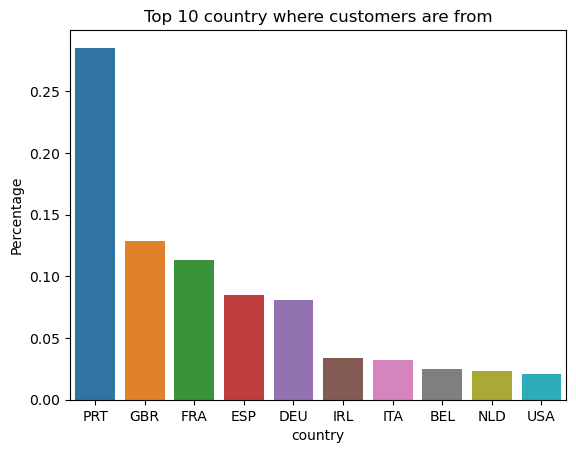

In [364]:
ax1 = sns.barplot(data=cgd[:10].transpose())
ax1.set(xlabel='country', ylabel='Percentage', title='Top 10 country where customers are from')
plt.show()

We can see from the plot that most of the customers are from Portugal. 

### Lead time distribution for cancelled orders

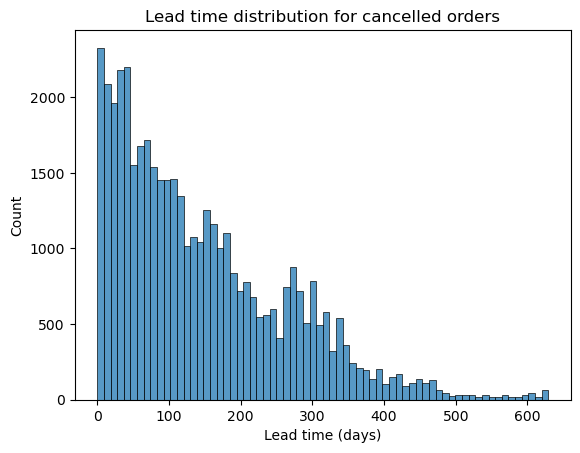

In [365]:
ax2 = sns.histplot(data[data['is_canceled']==1]['lead_time'])
ax2.set(ylabel='Count', xlabel='Lead time (days)', title='Lead time distribution for cancelled orders')
plt.show()

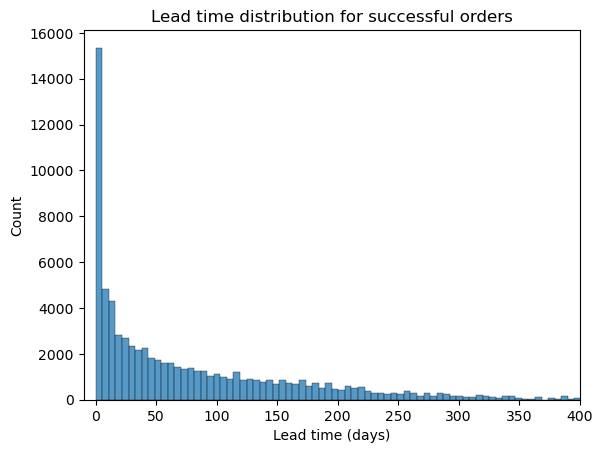

In [366]:
ax3 = sns.histplot(data[data['is_canceled']==0]['lead_time'])
ax3.set(ylabel='Count', xlabel='Lead time (days)', title='Lead time distribution for successful orders',
       xlim=(-10,400))
plt.show()

Lead time is defined as number of days that elapsed between the entering date of the booking into the PMS and the arrival date. From the comparison of lead time between cancelled orders and successful orders, it is obvious that successful offers have denser distribution at short lead time around 0-10 days. 

### Seasonality change about hotel orders and price

In [367]:
df1 = pd.DataFrame(data['arrival_date_month'].value_counts()).rename(columns={'arrival_date_month':'number of orders'})
df1

,number of orders
August,13861
July,12644
May,11780
October,11147
April,11078
June,10929
September,10500
March,9767
February,8052
November,6771


In [368]:
df2 = pd.DataFrame(data.groupby('arrival_date_month')['adr'].mean())
snlty = df2.join(df1)
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
snlty = snlty.reindex(new_order, axis=0)
snlty

,adr,number of orders
arrival_date_month,,
January,70.451631,5921
February,73.717054,8052
March,80.893217,9767
April,100.468146,11078
May,108.771400,11780
June,116.761489,10929
July,126.944704,12644
August,140.255303,13861
September,105.127290,10500


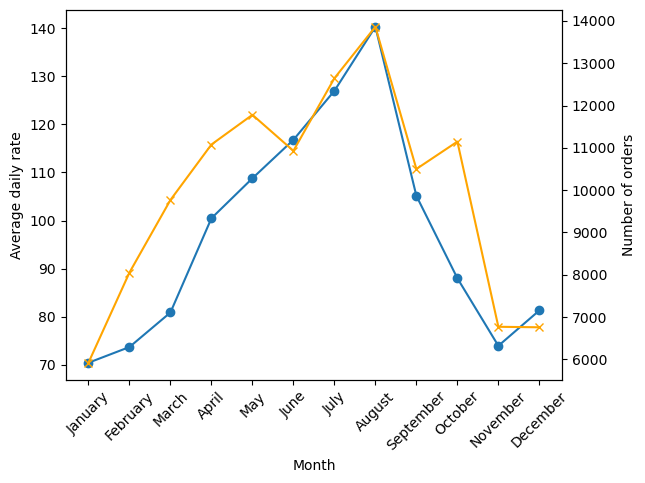

In [369]:
fig1, ax4 = plt.subplots()
ax4.plot(snlty.adr, marker='o')
ax4.set_xlabel('Month')
ax4.set_ylabel('Average daily rate')
plt.xticks(rotation=45)
ax5 = ax4.twinx()
ax5.plot(snlty['number of orders'], color='orange', marker='x')
ax5.set_ylabel('Number of orders')
plt.show()

There is much information in the plot:
* Number of orders peaked at August, around summer time.
* As the demand for hotel increases, the price increases accordingly, which is reasonable.

## Data Preprocessing

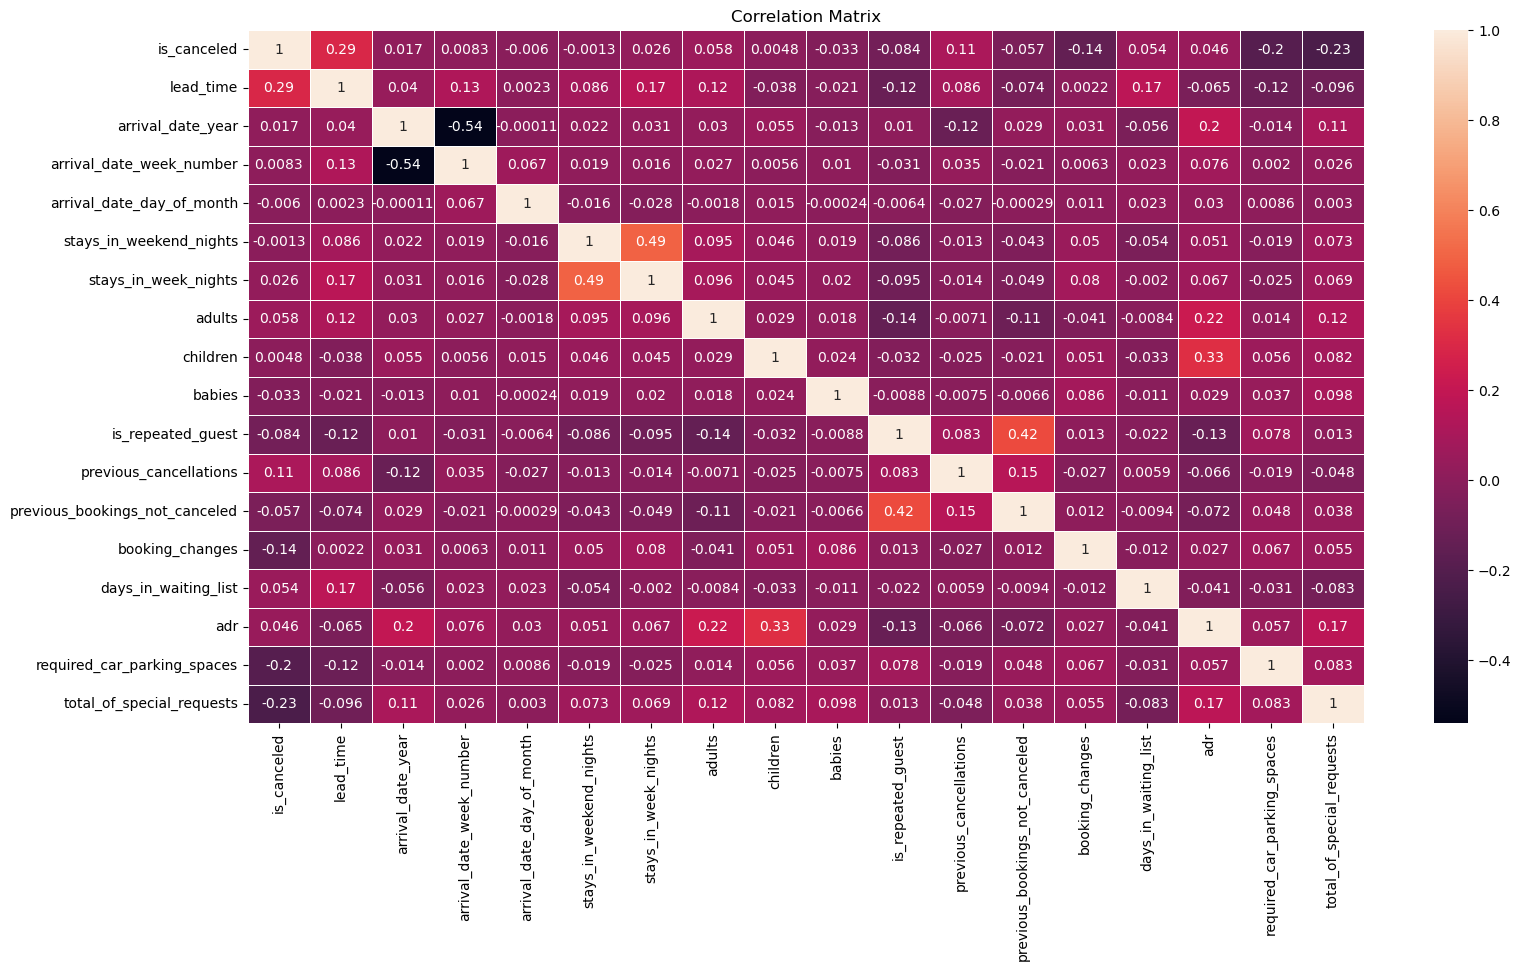

In [370]:
# check correlation matrix
plt.figure(figsize=(18,9))
sns.heatmap(data.corr(), annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

From the correlation plot, we did not see variables that are highly correlated with each other.

In [371]:
# remove some variables to improve accuracy and generalizability of models
data.drop(['reservation_status', 'country', 'arrival_date_year'], axis=1, inplace=True)

### Encode categorical variables

In [372]:
# check data
data.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,0,342,July,27,1,0,0,2,0.0,...,C,C,3,No Deposit,0,Transient,0.0,0,0,7/1/2015
1,Resort Hotel,0,737,July,27,1,0,0,2,0.0,...,C,C,4,No Deposit,0,Transient,0.0,0,0,7/1/2015
2,Resort Hotel,0,7,July,27,1,0,1,1,0.0,...,A,C,0,No Deposit,0,Transient,75.0,0,0,7/2/2015
3,Resort Hotel,0,13,July,27,1,0,1,1,0.0,...,A,A,0,No Deposit,0,Transient,75.0,0,0,7/2/2015
4,Resort Hotel,0,14,July,27,1,0,2,2,0.0,...,A,A,0,No Deposit,0,Transient,98.0,0,1,7/3/2015


In [373]:
data.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               

In [374]:
# take out categorical variables 
cate_col = [col for col in data.columns if data[col].dtype=='object']
cate_col

['hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date']

In [375]:
data_cate = data[cate_col]
data_cate.head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status_date
0,Resort Hotel,July,BB,Direct,Direct,C,C,No Deposit,Transient,7/1/2015
1,Resort Hotel,July,BB,Direct,Direct,C,C,No Deposit,Transient,7/1/2015
2,Resort Hotel,July,BB,Direct,Direct,A,C,No Deposit,Transient,7/2/2015
3,Resort Hotel,July,BB,Corporate,Corporate,A,A,No Deposit,Transient,7/2/2015
4,Resort Hotel,July,BB,Online TA,TA/TO,A,A,No Deposit,Transient,7/3/2015


In [376]:
# drop date variable
data_cate.drop(['reservation_status_date'], axis=1, inplace=True)
data_cate.head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
0,Resort Hotel,July,BB,Direct,Direct,C,C,No Deposit,Transient
1,Resort Hotel,July,BB,Direct,Direct,C,C,No Deposit,Transient
2,Resort Hotel,July,BB,Direct,Direct,A,C,No Deposit,Transient
3,Resort Hotel,July,BB,Corporate,Corporate,A,A,No Deposit,Transient
4,Resort Hotel,July,BB,Online TA,TA/TO,A,A,No Deposit,Transient


In [377]:
# check distinct values for each categorical variables 
for col in data_cate.columns:
    print(f"{col}: \n{data_cate[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

arrival_date_month: 
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal: 
['BB' 'FB' 'HB' 'SC' 'Undefined']

market_segment: 
['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

distribution_channel: 
['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

reserved_room_type: 
['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']

assigned_room_type: 
['C' 'A' 'D' 'E' 'G' 'F' 'I' 'B' 'H' 'L' 'K']

deposit_type: 
['No Deposit' 'Refundable' 'Non Refund']

customer_type: 
['Transient' 'Contract' 'Transient-Party' 'Group']



In [378]:
# One-hot encoding all the categorical variables 
data_cate_dum = pd.get_dummies(data_cate)

In [379]:
data_cate_dum.shape

(119209, 59)

Since I will use tree-based algorithms and logistic regression, I will not normalize my numerical variables.

In [380]:
# take out numerical variables
num_col = [col for col in data.columns if data[col].dtype!='object']
data_num = data[num_col]
data_num.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,27,1,0,0,2,0.0,0,0,0,0,3,0,0.0,0,0
1,0,737,27,1,0,0,2,0.0,0,0,0,0,4,0,0.0,0,0
2,0,7,27,1,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0
3,0,13,27,1,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0
4,0,14,27,1,0,2,2,0.0,0,0,0,0,0,0,98.0,0,1


In [381]:
# combine and get the final data set that we use in ML model
y = data_num['is_canceled']
data_num = data_num.drop('is_canceled', axis=1)
X = pd.concat([data_num, data_cate_dum], axis = 1)
X.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,27,1,0,0,2,0.0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,737,27,1,0,0,2,0.0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,7,27,1,0,1,1,0.0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,13,27,1,0,1,1,0.0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,14,27,1,0,2,2,0.0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Build ML Model

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [385]:
# check if the response variable is balanced
y.value_counts()

0    75010
1    44199
Name: is_canceled, dtype: int64

We can see that the response variable is not that balanced. When evaluating models, we need to consider comprehensice metrics like precision, recall and F1-score. 

### Logistic Regression

In [396]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

cm_lr_train = confusion_matrix(y_train, lr.predict(X_train))
cr_lr_train = classification_report(y_train, lr.predict(X_train))

cm_lr = confusion_matrix(y_test, y_pred_lr)
cr_lr = classification_report(y_test, y_pred_lr)

print(f"Confusion Matrix on training set: \n{cm_lr_train}")
print(f"Classification Report on training set: \n{cr_lr_train}")

print(f"Confusion Matrix on test set: \n{cm_lr}")
print(f"Classification Report on test set: \n{cr_lr}")

Confusion Matrix on training set: 
[[51299  5017]
 [12929 20161]]
Classification Report on training set: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     56316
           1       0.80      0.61      0.69     33090

    accuracy                           0.80     89406
   macro avg       0.80      0.76      0.77     89406
weighted avg       0.80      0.80      0.79     89406

Confusion Matrix on test set: 
[[16984  1710]
 [ 4324  6785]]
Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     18694
           1       0.80      0.61      0.69     11109

    accuracy                           0.80     29803
   macro avg       0.80      0.76      0.77     29803
weighted avg       0.80      0.80      0.79     29803



From the report, the model has similar performance on the training set and the test set. 

Logistic regression will serve as a benchmark model.

### Decision Tree

In [394]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

cm_dt_train = confusion_matrix(y_train, dt.predict(X_train))
cr_dt_train = classification_report(y_train, dt.predict(X_train))

cm_dt = confusion_matrix(y_test, y_pred_dt)
cr_dt = classification_report(y_test, y_pred_dt)

print(f"Confusion Matrix on training set: \n{cm_dt_train}")
print(f"Classification Report on training set: \n{cr_dt_train}")

print(f"Confusion Matrix on test set: \n{cm_dt}")
print(f"Classification Report on test set: \n{cr_dt}")

Confusion Matrix on training set: 
[[56120   196]
 [  496 32594]]
Classification Report on training set: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56316
           1       0.99      0.99      0.99     33090

    accuracy                           0.99     89406
   macro avg       0.99      0.99      0.99     89406
weighted avg       0.99      0.99      0.99     89406

Confusion Matrix on test set: 
[[15949  2745]
 [ 2532  8577]]
Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     18694
           1       0.76      0.77      0.76     11109

    accuracy                           0.82     29803
   macro avg       0.81      0.81      0.81     29803
weighted avg       0.82      0.82      0.82     29803



We can see that the model does way better on the training set compared to test set. Obviously, we have overfitting issue. So, we need to fine tune the parameters.

In [405]:
param_grid = {
    "max_depth":range(10,30,2),
    "min_samples_split":range(1,200,10),
    "max_features":range(30, 75, 15)
}
gs_dt = GridSearchCV(dt, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
gs_dt.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(10, 30, 2),
                         'max_features': range(30, 75, 15),
                         'min_samples_split': range(1, 200, 10)},
             verbose=1)

In [406]:
gs_dt.best_params_

{'max_depth': 18, 'max_features': 60, 'min_samples_split': 61}

In [407]:
y_pred_gs_dt = gs_dt.predict(X_test)

cm_gs_dt_train = confusion_matrix(y_train, gs_dt.predict(X_train))
cr_gs_dt_train = classification_report(y_train, gs_dt.predict(X_train))

cm_gs_dt = confusion_matrix(y_test, y_pred_gs_dt)
cr_gs_dt = classification_report(y_test, y_pred_gs_dt)

print(f"Confusion Matrix on training set: \n{cm_gs_dt_train}")
print(f"Classification Report on training set: \n{cr_gs_dt_train}")

print(f"Confusion Matrix on test set: \n{cm_gs_dt}")
print(f"Classification Report on test set: \n{cr_gs_dt}")

Confusion Matrix on training set: 
[[52065  4251]
 [ 8781 24309]]
Classification Report on training set: 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     56316
           1       0.85      0.73      0.79     33090

    accuracy                           0.85     89406
   macro avg       0.85      0.83      0.84     89406
weighted avg       0.85      0.85      0.85     89406

Confusion Matrix on test set: 
[[16915  1779]
 [ 3281  7828]]
Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     18694
           1       0.81      0.70      0.76     11109

    accuracy                           0.83     29803
   macro avg       0.83      0.80      0.81     29803
weighted avg       0.83      0.83      0.83     29803



From the output, we can see that the tuned model has a slightly better result compared to the untuned model concerning metrics of accuracy, presicion, recall and F1-score on the test set.

For 'is_canceled' = 1 prediction, the tuned model has higher precision and lower recall compared to the untuned model. The overall f1-score is the same. 

### Random Forest

In [408]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

cm_rf_train = confusion_matrix(y_train, rf.predict(X_train))
cr_rf_train = classification_report(y_train, rf.predict(X_train))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cr_rf = classification_report(y_test, y_pred_rf)

print(f"Confusion Matrix on training set: \n{cm_rf_train}")
print(f"Classification Report on training set: \n{cr_rf_train}")

print(f"Confusion Matrix on test set: \n{cm_rf}")
print(f"Classification Report on test set: \n{cr_rf}")

Confusion Matrix on training set: 
[[56046   270]
 [  424 32666]]
Classification Report on training set: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56316
           1       0.99      0.99      0.99     33090

    accuracy                           0.99     89406
   macro avg       0.99      0.99      0.99     89406
weighted avg       0.99      0.99      0.99     89406

Confusion Matrix on test set: 
[[17371  1323]
 [ 2605  8504]]
Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18694
           1       0.87      0.77      0.81     11109

    accuracy                           0.87     29803
   macro avg       0.87      0.85      0.86     29803
weighted avg       0.87      0.87      0.87     29803



From the result, we can see that the problem of overfitting exists. However, even if this is still an untuned model, the test set precision and recall are all better than previous models. I will tune this model below.

In [424]:
param_grid = {
    "n_estimators":range(200, 1000, 100),
    "max_depth":range(1, 30,5),
    "min_samples_split":range(1, 30,5),
    "max_features":range(15, 75, 5)
}
gs_ran_rf = RandomizedSearchCV(n_iter=500, estimator=rf, param_distributions=param_grid, cv=4, n_jobs=-1, verbose=1)
gs_ran_rf.fit(X_train, y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 30, 5),
                                        'max_features': range(15, 75, 5),
                                        'min_samples_split': range(1, 30, 5),
                                        'n_estimators': range(200, 1000, 100)},
                   verbose=1)

In [425]:
gs_ran_rf.best_params_

{'n_estimators': 700,
 'min_samples_split': 6,
 'max_features': 40,
 'max_depth': 26}

In [426]:
y_pred_gs_ran_rf = gs_ran_rf.predict(X_test)

cm_gs_ran_rf_train = confusion_matrix(y_train, gs_ran_rf.predict(X_train))
cr_gs_ran_rf_train = classification_report(y_train, gs_ran_rf.predict(X_train))

cm_gs_ran_rf = confusion_matrix(y_test, y_pred_gs_ran_rf)
cr_gs_ran_rf = classification_report(y_test, y_pred_gs_ran_rf)

print(f"Confusion Matrix on training set: \n{cm_gs_ran_rf_train}")
print(f"Classification Report on training set: \n{cr_gs_ran_rf_train}")

print(f"Confusion Matrix on test set: \n{cm_gs_ran_rf}")
print(f"Classification Report on test set: \n{cr_gs_ran_rf}")

Confusion Matrix on training set: 
[[55248  1068]
 [ 2697 30393]]
Classification Report on training set: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     56316
           1       0.97      0.92      0.94     33090

    accuracy                           0.96     89406
   macro avg       0.96      0.95      0.95     89406
weighted avg       0.96      0.96      0.96     89406

Confusion Matrix on test set: 
[[17288  1406]
 [ 2632  8477]]
Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     18694
           1       0.86      0.76      0.81     11109

    accuracy                           0.86     29803
   macro avg       0.86      0.84      0.85     29803
weighted avg       0.86      0.86      0.86     29803



In [427]:
param_grid = {
    "n_estimators":[600, 700, 800, 900],
    "max_depth":[25, 28, 32, 36, 40],
    "min_samples_split":[2, 4, 6, 8],
    "max_features":[35, 40, 45]
}
gs_rf = GridSearchCV(rf, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

Fitting 4 folds for each of 240 candidates, totalling 960 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [25, 28, 32, 36, 40],
                         'max_features': [35, 40, 45],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [600, 700, 800, 900]},
             verbose=1)

In [428]:
gs_rf.best_params_

{'max_depth': 28,
 'max_features': 35,
 'min_samples_split': 2,
 'n_estimators': 800}

In [429]:
y_pred_gs_rf = gs_rf.predict(X_test)

cm_gs_rf_train = confusion_matrix(y_train, gs_rf.predict(X_train))
cr_gs_rf_train = classification_report(y_train, gs_rf.predict(X_train))

cm_gs_rf = confusion_matrix(y_test, y_pred_gs_rf)
cr_gs_rf = classification_report(y_test, y_pred_gs_rf)

print(f"Confusion Matrix on training set: \n{cm_gs_rf_train}")
print(f"Classification Report on training set: \n{cr_gs_rf_train}")

print(f"Confusion Matrix on test set: \n{cm_gs_rf}")
print(f"Classification Report on test set: \n{cr_gs_rf}")

Confusion Matrix on training set: 
[[55873   443]
 [  772 32318]]
Classification Report on training set: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56316
           1       0.99      0.98      0.98     33090

    accuracy                           0.99     89406
   macro avg       0.99      0.98      0.99     89406
weighted avg       0.99      0.99      0.99     89406

Confusion Matrix on test set: 
[[17251  1443]
 [ 2517  8592]]
Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     18694
           1       0.86      0.77      0.81     11109

    accuracy                           0.87     29803
   macro avg       0.86      0.85      0.85     29803
weighted avg       0.87      0.87      0.87     29803



From the result, we can see that the grid search result is slightly better than the randomized search, concerning recall and accuracy. However, the metrics are the same compared to the untune model. So, I will use the result of the untune model. 

### Model Summary

In [430]:
# logistic regression result
print(f"Classification Report on test set: \n{cr_lr}")

Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     18694
           1       0.80      0.61      0.69     11109

    accuracy                           0.80     29803
   macro avg       0.80      0.76      0.77     29803
weighted avg       0.80      0.80      0.79     29803



In [431]:
# decision tree result
print(f"Classification Report on test set: \n{cr_gs_dt}")

Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.84      0.90      0.87     18694
           1       0.81      0.70      0.76     11109

    accuracy                           0.83     29803
   macro avg       0.83      0.80      0.81     29803
weighted avg       0.83      0.83      0.83     29803



In [432]:
# random forest result
print(f"Classification Report on test set: \n{cr_gs_rf}")

Classification Report on test set: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     18694
           1       0.86      0.77      0.81     11109

    accuracy                           0.87     29803
   macro avg       0.86      0.85      0.85     29803
weighted avg       0.87      0.87      0.87     29803



We can compare the metrics on the test set for the three models. We mainly compare the precision, recall and f1-score on the 'is_canceled' == 1 prediction, and the overall accuracy. The random forest model gave the best result concerning all these metrics, with 0.86 precision, 0.77 recall and 0.87 accuracy. 